In [3]:
#importing libraries required
import os
import cv2
import json
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import albumentations as A
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

2025-04-15 12:07:14.729722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744718834.968093      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744718835.038211      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
#loading the data

whole_dataset = '/kaggle/input/soldef-ai-pcb-dataset-for-defect-detection/SolDef_AI/Dataset'
labeled_dir = '/kaggle/input/soldef-ai-pcb-dataset-for-defect-detection/SolDef_AI/Labeled'

IMG_SIZE = (224, 224)

#function to load the labeled data
def load_labeled_data(directory):
    images, masks, labels = [], [], []
    for file in tqdm(os.listdir(directory)):
        if file.endswith('.json'):
            json_path = os.path.join(directory, file)
            with open(json_path) as f:
                data = json.load(f)
            image_path = os.path.join(directory, data['imagePath'])
            if not os.path.exists(image_path):
                continue

            img = cv2.imread(image_path)
            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0

            # create mask based on polygon
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            for shape in data['shapes']:
                label = shape['label']
                points = np.array(shape['points'], dtype=np.int32)
                cv2.fillPoly(mask, [points], color=1)
                images.append(img)
                masks.append(mask)
                labels.append(label)
    return np.array(images), np.array(masks), np.array(labels)

images, masks, labels = load_labeled_data(labeled_dir)


100%|██████████| 856/856 [00:24<00:00, 34.35it/s]


In [5]:
#label encoding 
#doing label encoding
y = LabelEncoder().fit_transform(labels)

# Split data into training and validation set (here named temp) and test sets
X_temp, X_test, y_temp, y_test = train_test_split(images, y, test_size=0.1, stratify=y, random_state=42)
y_temp_cat = to_categorical(y_temp)
y_test_cat = to_categorical(y_test)

In [6]:
# data augmnentation:
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5)
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
#building the cnn model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
#using k fold cross-validation on the temp dataset for training and validation set
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_model = None
best_val_accuracy = 0

for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp, y_temp)):
    print(f"\n--- Fold {fold+1} ---")
    X_train, X_val = X_temp[train_idx], X_temp[val_idx]
    y_train, y_val = y_temp_cat[train_idx], y_temp_cat[val_idx]

    X_train_aug = []
    for img in X_train:
        augmented = aug(image=img)['image']
        X_train_aug.append(augmented)
    X_train_aug = np.array(X_train_aug)

    model = build_cnn((*IMG_SIZE, 3), len(np.unique(y)))
    early_stop = EarlyStopping(patience=5, restore_best_weights=True)

    history = model.fit(X_train_aug, y_train, validation_data=(X_val, y_val),
                        epochs=20, batch_size=32, callbacks=[early_stop])

    val_acc = history.history['val_accuracy'][-1]
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model = model


--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-15 12:08:02.130872: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.2870 - loss: 16.2131 - val_accuracy: 0.2645 - val_loss: 3.3169
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.3731 - loss: 6.2951 - val_accuracy: 0.2645 - val_loss: 4.3679
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.3800 - loss: 1.7788 - val_accuracy: 0.3223 - val_loss: 8.9316
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.3483 - loss: 1.5460 - val_accuracy: 0.2562 - val_loss: 10.8261
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.3678 - loss: 1.4882 - val_accuracy: 0.1818 - val_loss: 12.8763
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.4587 - loss: 1.2468 - val_accuracy: 0.2479 - val_loss: 15.7608

--- Fold 2 ---
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.2542 - loss: 15.2930 - val_accuracy: 0.1653 - val_loss: 2.2736
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.3104 - loss: 3.5523 - val_accurac

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
              precision    recall  f1-score   support

           0       0.38      0.78      0.51        18
           1       0.23      0.26      0.24        19
           2       0.57      0.33      0.42        12
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        13

    accuracy                           0.34        68
   macro avg       0.24      0.27      0.23        68
weighted avg       0.26      0.34      0.28        68



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


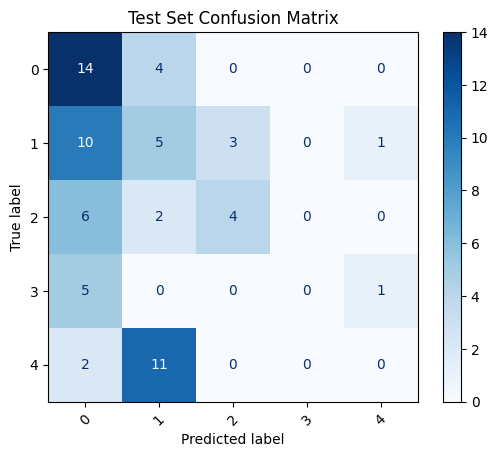

In [9]:
y_test_pred = np.argmax(best_model.predict(X_test), axis=1)
y_test_true = np.argmax(y_test_cat, axis=1)
print(classification_report(y_test_true, y_test_pred))
cm = confusion_matrix(y_test_true, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Test Set Confusion Matrix")
plt.show()

In [10]:
#trying to fix data imbalance problem:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
LE = LabelEncoder()
y_temp_encoded = LE.fit_transform(y_temp)
class_weights_dict = {i: class_weights[i] for i in range(len(LE.classes_))}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_model = None
best_val_accuracy = 0

for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp, y_temp)):
    print(f"\n--- Fold {fold+1} ---")
    X_train, X_val = X_temp[train_idx], X_temp[val_idx]
    y_train, y_val = y_temp_cat[train_idx], y_temp_cat[val_idx]

    X_train_aug = []
    for img in X_train:
        augmented = aug(image=img)['image']
        X_train_aug.append(augmented)
    X_train_aug = np.array(X_train_aug)

    model_1 = build_cnn((*IMG_SIZE, 3), len(LE.classes_))
    early_stop = EarlyStopping(patience=5, restore_best_weights=True)

    history_1 = model_1.fit(X_train_aug, y_train, validation_data=(X_val, y_val),
                        epochs=20, batch_size=32, class_weight=class_weights_dict, callbacks=[early_stop])

    val_acc = history_1.history['val_accuracy'][-1]
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_1 = model_1


--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.2781 - loss: 13.8391 - val_accuracy: 0.2149 - val_loss: 2.7225
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.2615 - loss: 3.4480 - val_accuracy: 0.1074 - val_loss: 7.6071
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.2697 - loss: 2.4151 - val_accuracy: 0.2066 - val_loss: 12.3628
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.4194 - loss: 1.5986 - val_accuracy: 0.1074 - val_loss: 16.7297
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.3391 - loss: 1.7238 - val_accuracy: 0.0826 - val_loss: 18.3320
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.3160 - loss: 1.5649 - val_accuracy: 0.0826 - val_loss: 18.1267

--- Fold 2 ---
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.2568 - loss: 23.4196 - val_accuracy: 0.2645 - val_loss: 2.2921
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.3858 - loss: 7.0510 - val_accura

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step
              precision    recall  f1-score   support

           0       0.57      0.44      0.50        18
           1       0.42      0.42      0.42        19
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         6
           4       0.31      0.85      0.46        13

    accuracy                           0.40        68
   macro avg       0.26      0.34      0.28        68
weighted avg       0.33      0.40      0.34        68



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


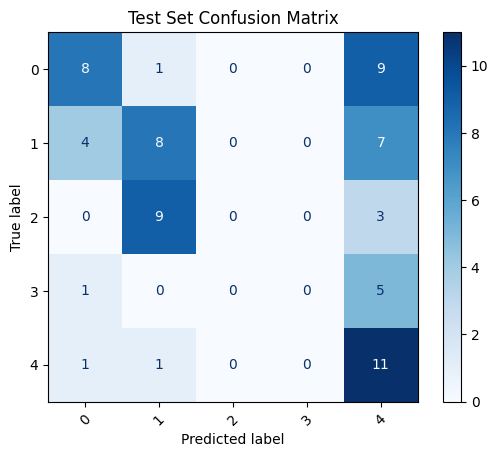

In [11]:
# became more imabalanced as a result
y_test_pred = np.argmax(best_model_1.predict(X_test), axis=1)
y_test_true = np.argmax(y_test_cat, axis=1)

print(classification_report(y_test_true, y_test_pred))

cm = confusion_matrix(y_test_true, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Test Set Confusion Matrix")
plt.show()

In [12]:


def train_model_with_kfold(model_name, X_temp, y_temp, loss_fn, oversample=False):
    print(f"\n Training: {model_name}")
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_model = None
    best_val_acc = 0

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp, y_temp)):
        print(f"\n Fold {fold+1}")
        X_train, X_val = X_temp[train_idx], X_temp[val_idx]
        y_train, y_val = y_temp[train_idx], y_temp[val_idx]

        if oversample:
            X_flat = X_train.reshape(X_train.shape[0], -1)
            ros = RandomOverSampler(random_state=42)
            X_resampled, y_train = ros.fit_resample(X_flat, y_train)
            X_train = X_resampled.reshape(-1, 224, 224, 3)

        y_train_cat = to_categorical(y_train)
        y_val_cat = to_categorical(y_val)

        model = build_cnn((224, 224, 3), len(np.unique(y_temp)))
        model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
        early_stop = EarlyStopping(patience=5, restore_best_weights=True)

        model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),
                  epochs=20, batch_size=32, callbacks=[early_stop], verbose=0)

        val_acc = model.evaluate(X_val, y_val_cat, verbose=0)[1]
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model

    return best_model


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_temp)
class_names = le.classes_


In [13]:
#using focal loss to reduce class imbalance:
import tensorflow.keras.backend as K
from tensorflow.keras.losses import categorical_crossentropy

def focal_loss(gamma=2., alpha=.25):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        ce = categorical_crossentropy(y_true, y_pred)
        pt = tf.exp(-ce)
        return K.mean(alpha * (1 - pt) ** gamma * ce)
    return loss_fn
focal_model = train_model_with_kfold("Focal Loss", X_temp, y_temp, loss_fn=focal_loss())



 Training: Focal Loss

 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Fold 2

 Fold 3

 Fold 4

 Fold 5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step

 Focal Loss Model - Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.94      0.52        18
           1       0.00      0.00      0.00        19
           2       0.31      0.33      0.32        12
           3       0.00      0.00      0.00         6
           4       0.29      0.15      0.20        13

    accuracy                           0.34        68
   macro avg       0.19      0.29      0.21        68
weighted avg       0.20      0.34      0.23        68

 Focal Loss Model - Balanced Accuracy: 0.2863


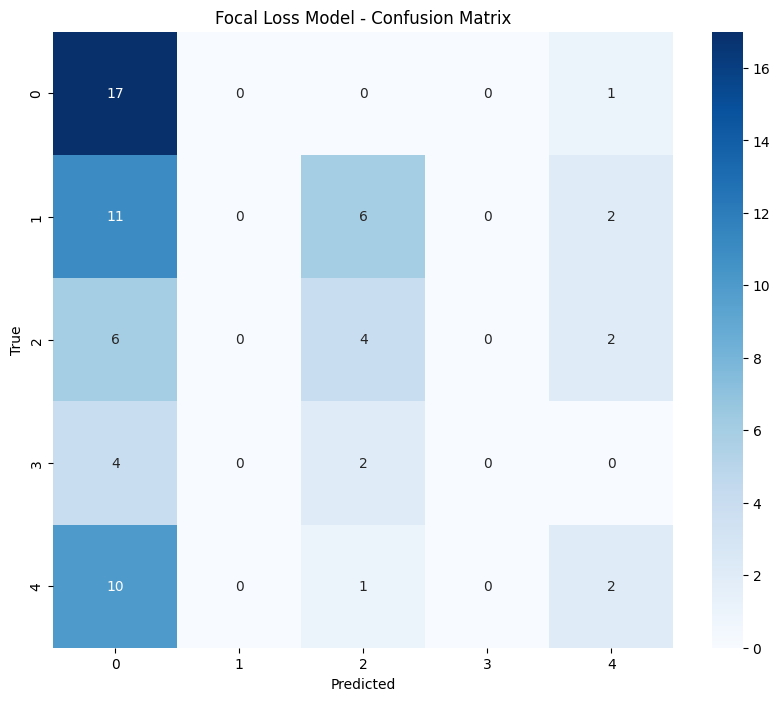

In [15]:
from sklearn.metrics import classification_report, balanced_accuracy_score
import seaborn as sns
def evaluate_model(model, name):
    preds = model.predict(X_test)
    y_pred = np.argmax(preds, axis=1)
    target_names = [str(cls) for cls in le.classes_]

    print(f"\n {name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))
    print(f" {name} - Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(focal_model, "Focal Loss Model")